In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn import preprocessing
import numpy as np
import math

def createStrToNumDict(data): # Creates a dict to convert between the string labels to numeric values
    dataAvg = data.groupby("label").mean() # creates matrix with one row per glitch and avg dimension values in the columns
    numGlitches = len(data["label"].unique())
    min_max_scaler = preprocessing.MinMaxScaler() # for normalization so distances are standard [0, 1]
    normalized_nD = min_max_scaler.fit_transform(dataAvg)
    distances = dict() # dictionary to store every glitch's mean distance value
    labels_sorted = np.sort(data["label"].unique()) # labels sorted in alphab. because that's how dataAvg and norm_nD are
    for i in range(len(labels_sorted)):
        distances[labels_sorted[i]] = getDistance(normalized_nD[i], 0.0) # get distance to origin as metric of similarity
    maxValue = max(distances.values()) #maxValue is needed for normalization of final distance to [0, 1]
    for key in distances.keys():
        distances[key] = 1 - ((maxValue - distances[key]) / (maxValue)) # norm. as described above
    sortedDist = sorted(distances.items(), key=lambda x: x[1]) # sort distances by glitch name (alphab) to match labels
    count = 0
    convertionDict = dict() # final dictionary: now glitches are in order of similarity 
    for tup in sortedDist:
        convertionDict[tup[0]] = count
        count += 1
    return convertionDict

In [3]:
def convertNumLabelsToString(numList, convertionDict): #convertionDict must be the strToNumDict
    converted = [i for i in numList] # deep copy
    numToStrDict = dict()
    key = 0
    for label in list(convertionDict.keys()): # values are in the same order as the convertionDict so this is safe
        numToStrDict[key] = label
        key += 1
    for i in range(len(converted)):
        converted[i] = str(numToStrDict[int(converted[i])]) # puts the converted list the stringVal corresponding to the intLabel
    return converted

In [4]:
def getDistance(datapoint, center):
    distSqrd = 0
    for i in range(len(datapoint)):
        distSqrd += (datapoint[i] - center)**2
    return math.sqrt(distSqrd)

In [6]:
import pandas as pd

df = pd.read_csv("trainingset_v1d1_metadata.csv")
relevant_columns = [ # Selects all potentially meaningful features to go through feature selection
    "event_time",
    "peak_time",
    "start_time",
    "duration",
    "peak_frequency",
    "central_freq",
    "bandwidth",
    "amplitude",
    "snr", 
    "param_one_value"
]
toSelect = df[relevant_columns] # columns which will go through feature selection

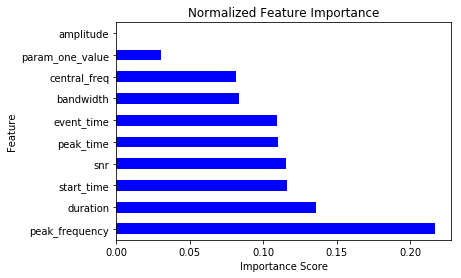

peak_frequency     0.216999
duration           0.135868
start_time         0.116458
snr                0.115796
peak_time          0.110146
event_time         0.109269
bandwidth          0.083335
central_freq       0.081577
param_one_value    0.030552
amplitude          0.000000
dtype: float64


In [29]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(toSelect, df["label"])
feat_importances = pd.Series(model.feature_importances_, index=toSelect.columns) # get the 
feat_importances = feat_importances.sort_values(ascending=False)
feat_importances.plot(kind='barh', cmap="winter")
plt.title("Normalized Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()
print(feat_importances)

In [30]:
features = [
    "peak_frequency",
    "snr",
    "duration",
    "start_time",
    "event_time",
    "label"
]

features = df[features]
labels = df["label"]

strToNumDict = createStrToNumDict(features) # labels are string values, but most become numerical for the model

labels = labels.replace(strToNumDict) # replaces the string value with its equivalent num label
features = features.drop(["label"], axis=1) # separate features from the labels

In [31]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=66)

y_train = pd.get_dummies(y_train) 
y_test = pd.get_dummies(y_test)

In [32]:
%%time

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import statistics
import sys

mean_scores = list()
max_scores = list()
stdev_scores = list()
rank_score = list() # this list will be a combination of mean and max, to give a better "best" estimator 

maxNumEstimators = 100

x_range = [i+1 for i in range(maxNumEstimators)]

for i in x_range:
    rf = RandomForestClassifier(n_estimators=i, bootstrap = True) # varying number of trees in the forest
    rf.fit(x_train, y_train)
    preds = rf.predict(x_test)
    sc = cross_val_score(rf, y_test, preds)
    mean_scores += [statistics.mean(sc)]
    max_scores += [max(sc)]
    stdev_scores += [statistics.stdev(sc)]
    rank = 0.75 * statistics.mean(sc) + 0.25 * max(sc)
    rank_score += [rank]
    sys.stdout.write(str(i) + " - ") # keep track of iteration progress

bestScore = max(rank_score)
bestEstimator = rank_score.index(bestScore) + 1 # The +1 comes from index k representing k+1 estimators

print("") # new lines
print("")
print("Best Estimator: " + str(bestEstimator))
print("Best Rank Score: " + str(max(rank_score)))
rf = RandomForestClassifier(n_estimators=bestEstimator, bootstrap = True) # re-create the best forest
rf.fit(x_train, y_train)
preds = rf.predict(x_test)

1 - 2 - 3 - 4 - 5 - 6 - 7 - 8 - 9 - 10 - 11 - 12 - 13 - 14 - 15 - 16 - 17 - 18 - 19 - 20 - 21 - 22 - 23 - 24 - 25 - 26 - 27 - 28 - 29 - 30 - 31 - 32 - 33 - 34 - 35 - 36 - 37 - 38 - 39 - 40 - 41 - 42 - 43 - 44 - 45 - 46 - 47 - 48 - 49 - 50 - 51 - 52 - 53 - 54 - 55 - 56 - 57 - 58 - 59 - 60 - 61 - 62 - 63 - 64 - 65 - 66 - 67 - 68 - 69 - 70 - 71 - 72 - 73 - 74 - 75 - 76 - 77 - 78 - 79 - 80 - 81 - 82 - 83 - 84 - 85 - 86 - 87 - 88 - 89 - 90 - 91 - 92 - 93 - 94 - 95 - 96 - 97 - 98 - 99 - 100 - 

Best Estimator: 77
Best Rank Score: 0.8785868272375854
Wall time: 4min 27s


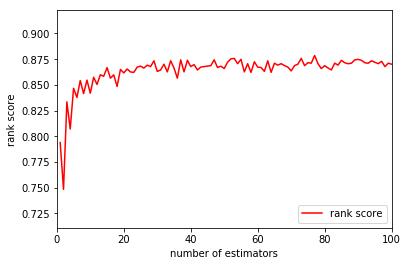

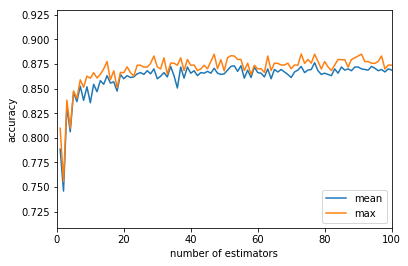

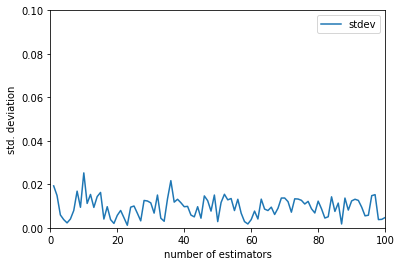

In [35]:
import matplotlib.pyplot as plt

plt.plot(x_range, rank_score, 'r')
plt.axis([0, maxNumEstimators, 0.95*min(rank_score), 1.05*max(rank_score)])
plt.xlabel("number of estimators")
plt.ylabel("rank score")
plt.legend(["rank score"], loc='lower right')
plt.show()

plt.plot(x_range, mean_scores, x_range, max_scores)
plt.axis([0, maxNumEstimators, 0.95*min(min(mean_scores, max_scores)), 1.05*max(max(mean_scores, max_scores))])
plt.xlabel("number of estimators")
plt.ylabel("accuracy")
plt.legend(["mean", "max"], loc='lower right')
plt.show()

plt.plot(x_range, stdev_scores)
plt.axis([0, maxNumEstimators, 0, 0.1])
plt.xlabel("number of estimators")
plt.ylabel("std. deviation")
plt.legend(["stdev"], loc='upper right')
plt.show()

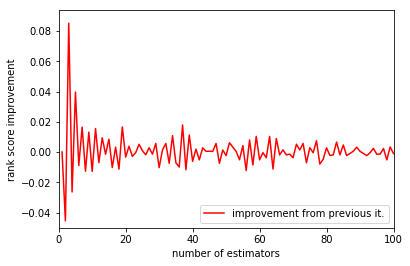

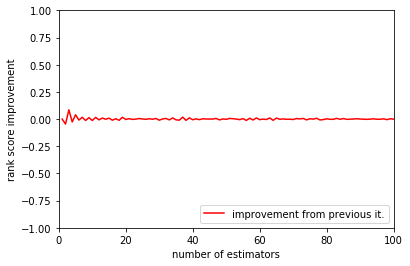

In [40]:
# Check if there's still meaningful score increase from training on more classifiers 

rank_improvent = [0]
i = 1
while i < len(rank_score):
    rank_improvent += [rank_score[i] - rank_score[i-1]]
    i += 1
plt.plot(x_range, rank_improvent, 'r')
plt.axis([0, maxNumEstimators, 1.1*min(rank_improvent), 1.1*max(rank_improvent)])
plt.xlabel("number of estimators")
plt.ylabel("rank score improvement")
plt.legend(["improvement from previous it."], loc='lower right')
plt.show()

plt.plot(x_range, rank_improvent, 'r')
plt.axis([0, maxNumEstimators, -1, 1])
plt.xlabel("number of estimators")
plt.ylabel("rank score improvement")
plt.legend(["improvement from previous it."], loc='lower right')
plt.show()

In [46]:
preds_1D = list() # we must take the most likely glitch for every row in preds so we can have a 1D array
for row in preds:
    if max(row) > 0:
        preds_1D += [list(row).index(max(row))]
    else:
        preds_1D += [strToNumDict["None_of_the_Above"]] # if couldn't find a glitch, predict "None_of_the_Above"
preds_1D = pd.Series(preds_1D)

y_test_1D = list() # same will be repeated for the y_test labels
for row in np.array(y_test):
    if max(row) > 0:
        y_test_1D += [list(row).index(max(row))]
    else:
        y_test_1D += [10] # 10 is the prediction for "None_Of_The_Above"
y_test_1D = pd.Series(y_test_1D)

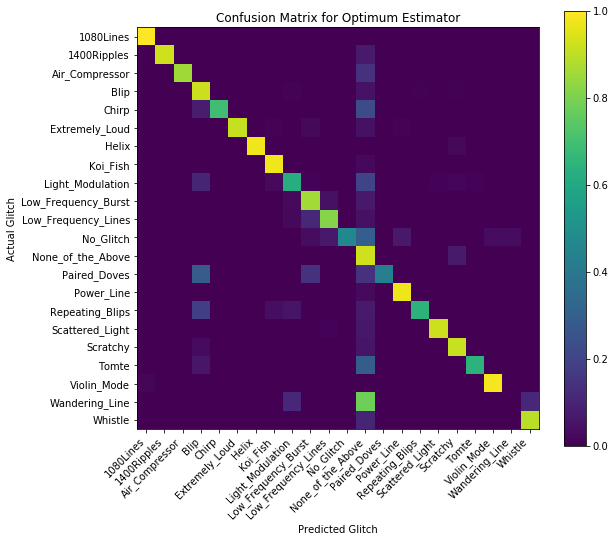

In [47]:
# Run these lines if you don't have pandas_ml installed:
    # import sys
    # !{sys.executable} -m pip install pandas_ml 

from pandas_ml import ConfusionMatrix

str_preds_1D = convertNumLabelsToString(preds_1D, strToNumDict) # the strToNumDict was defined at the very beggining 
str_y_test_1D = convertNumLabelsToString(y_test_1D, strToNumDict)

confusion_matrix = ConfusionMatrix(str_y_test_1D, str_preds_1D)
confusion_matrix.plot(normalized=True)
plt.set_cmap('viridis')
plt.xlabel("Predicted Glitch")
plt.ylabel("Actual Glitch")
plt.title("Confusion Matrix for Optimum Estimator")
plt.show()